#1.Import library and import data

In [ ]:
from torch import nn
import torch
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms

from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.nn import LogSoftmax
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision.models.resnet import resnet50,resnet34
# from torchsummary import summary
import cv2
from torch.cuda.amp import GradScaler, autocast
#"/content/drive/MyDrive/Facial expression regcogconition/CK+48"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
data = pd.read_csv("/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv")

#2.Specify hyperparameters

In [ ]:
# Hyperparamters:
epochs = 150

# batch_size
batch_size = 64

#learning_rate:
learning_rate = 0.03

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


checkpoint_path = '/kaggle/working/Express_model.pth'

#3.Custom Datasets

In [ ]:
class custom_datasets(Dataset):
  def __init__(self,dataframe,transform = None):
    super().__init__()
    self.data = dataframe
    self.transform = transform



  def change_to_image(self,x):
    img = np.array(x.split(),dtype = np.int8)
    img = img.reshape((48,48))
    img = Image.fromarray(img)
    return img

  def __getitem__(self,index):
    image = self.change_to_image(self.data.loc[index,"pixels"])
    label = self.data.loc[index, "emotion"]
    if self.transform:
      image = self.transform(image)

    return (image,label)



  def __len__(self):
    return self.data.index.size






In [ ]:
mu, st = 0, 255
# test transforms:
test_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack(
            [transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack(
            [transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    ])

# Train_transforms:

train_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.RandomApply([transforms.ColorJitter(
                brightness=0.5, contrast=0.5, saturation=0.5)], p=0.5),
            transforms.RandomApply(
                [transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
            transforms.FiveCrop(40),
            transforms.Lambda(lambda crops: torch.stack(
                [transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda tensors: torch.stack(
                [transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
            transforms.Lambda(lambda tensors: torch.stack(
                [transforms.RandomErasing()(t) for t in tensors])),
        ])

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mu,), std=(st,))
])

In [ ]:
train = data[data.loc[:,"Usage"] == "Training"].loc[:,:]
valid = data[data.loc[:,"Usage"] == "PublicTest"]
valid.index = range(0,valid.index.size)
test = data[data.loc[:,"Usage"] == "PrivateTest"]
test.index = range(0,test.index.size)



train_datasets = custom_datasets(dataframe = train,transform = train_transform)
valid_datasets = custom_datasets(dataframe = valid,transform = test_transform)
test_datasets = custom_datasets(dataframe = test,transform = test_transform)

In [ ]:
test_datasets_predict = custom_datasets(dataframe = test,transform = transform)
predict_dataloader = DataLoader(test_datasets_predict, batch_size = 8, shuffle = False)

In [ ]:
train_dataloader = DataLoader(train_datasets, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_datasets, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_datasets, batch_size = batch_size, shuffle = False)

#3.Build Model

##3.1. Basic Block, ResNet18, ResNet34

In [ ]:
class Residual(nn.Module):
  """The Residual block of ResNet models."""
  def __init__(self, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
    stride=strides)
    self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
      stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()
  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

In [ ]:
# model
class ResNet(nn.Module):
  def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.lr = lr
    self.num_classes = num_classes
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
      self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
    nn.LazyLinear(num_classes)))


  def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
      if i == 0 and not first_block:
        blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
      else:
        blk.append(Residual(num_channels))
    return nn.Sequential(*blk)


  def b1(self):
    return nn.Sequential(
    nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
    nn.LazyBatchNorm2d(), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

  def forward(self,X):
    return self.net(X)

In [ ]:
class ResNet34(ResNet):
  def __init__(self, lr=0.1, num_classes=7):
    super().__init__(((3, 64), (4, 128), (6, 256), (3, 512)),
    lr, num_classes)


In [ ]:
class ResNet18(ResNet):
  def __init__(self, lr=0.1, num_classes=7):
    super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
    lr, num_classes)


##3.2 Bottleneck, ResNet50,ResNet101,ResNet152

In [ ]:
class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(self,inplanes: int,planes: int,stride: int = 1,downsample=None):
        super().__init__()
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes, stride,padding = 1)
        self.bn2 = norm_layer(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet_(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes: int = 1000,
        zero_init_residual: bool = False):
        super().__init__()
        self._norm_layer = nn.BatchNorm2d

        self.inplanes = 64


        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.fc = nn.Sequential(
        nn.Linear(512 * block.expansion, 512),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(512, 128),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(128, 7),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1) :
        norm_layer = self._norm_layer
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self,x):
        return self._forward_impl(x)

In [ ]:
def ResNet50():
    return ResNet_(Bottleneck, [3,4,6,3],num_classes = 7,zero_init_residual=True)

In [ ]:
def ResNet101():
    return ResNet_(Bottleneck, [3,4,23,3],num_classes = 7,zero_init_residual=True)

In [ ]:
def ResNet152():
    return ResNet_(Bottleneck, [3,8,36,3],num_classes = 7,zero_init_residual=True)

#4.Training

In [ ]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

In [ ]:
#model
model = ResNet18()
model.to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ResNet18(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (b2): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentu

In [ ]:
def accuracy(outputs, targets):
    predicted_class = torch.argmax(outputs, dim = 1)
    boolean = []
    for i in range(len(targets)):
        if predicted_class[i] == targets[i]:
            boolean.append(1)
        else:
            boolean.append(0)
    return sum(boolean)/len(boolean)

In [ ]:
def fit_epoch(epoch, model, optimizer,train_dataloader):
  loss_epochs = 0
  acc_epochs = 0
  print(f"learning_rate:{optimizer.param_groups[0]['lr']}" )
  for img, label in train_dataloader:
    with autocast():
        bs,nCrop,c,h,w = img.shape
        img = img.view(-1,c,h,w)

        label = torch.repeat_interleave(label, repeats=nCrop, dim=0)

        # Change in into gpu:
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        # feed forward data:
        outputs = model(img)

        # loss function:
        loss = loss_fn(outputs, label)

    # optimizer step:
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()


    #gather loss metrics:
    loss_epochs += loss.item()
    acc_epochs += accuracy(outputs, label)

  print(f"Epoch {epoch + 1}: train_loss: {loss_epochs/len(train_dataloader)}, train_acc: {acc_epochs/len(train_dataloader)}")
  return loss_epochs/len(train_dataloader),acc_epochs/len(train_dataloader)

In [ ]:
#Specify loss function and optimizer:
loss_fn = nn.CrossEntropyLoss()

# optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# learning_rate scheduler:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.75, patience=5, verbose=True)

scaler = GradScaler()


In [ ]:
save_model(model, optimizer, checkpoint_path)

In [ ]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
last_acc = 0

for epoch in range(epochs):
  print(f"Epoch {epoch + 1}:")
  model.train(True)

  t_loss, t_acc = fit_epoch(epoch,model,optimizer,train_dataloader)
  train_loss.append(t_loss)
  train_acc.append(t_acc)

  # valid evaluation:

  model.eval()
  valid_loss = 0
  valid_acc = 0
  with torch.no_grad():
    for img, label in valid_dataloader:
      bs,nCrop,c,h,w = img.shape
      img = img.view(-1,c,h,w)

      img = img.to(device)
      label = label.to(device)

      outputs = model(img)

      outputs = outputs.view(bs, nCrop, -1)
      outputs = torch.sum(outputs, dim=1) / nCrop

      vloss = loss_fn(outputs, label)
      valid_loss += vloss.item()
      valid_acc += accuracy(outputs,label)

    val_loss.append(valid_loss/len(valid_dataloader))
    valid_accuracy = valid_acc/len(valid_dataloader)
    val_acc.append(valid_accuracy)

  print(f"Epoch {epoch + 1}: valid_loss: {valid_loss/len(valid_dataloader)}, valid_acc: {valid_accuracy}")

  if valid_accuracy > last_acc:
        save_model(model, optimizer, checkpoint_path)
        last_acc = valid_accuracy


  scheduler.step(valid_accuracy)







Epoch 1:
learning_rate:0.001
Epoch 1: train_loss: 1.8161636861767163, train_acc: 0.2436220881237585
Epoch 1: valid_loss: 1.8046730003858868, valid_acc: 0.24857456140350875
Epoch 2:
learning_rate:0.001
Epoch 2: train_loss: 1.6973750920497495, train_acc: 0.31501779479925357
Epoch 2: valid_loss: 2.0894918629997656, valid_acc: 0.24857456140350875
Epoch 3:
learning_rate:0.001
Epoch 3: train_loss: 1.5801385572068145, train_acc: 0.3789919791729367
Epoch 3: valid_loss: 1.9875102356860512, valid_acc: 0.22982456140350876
Epoch 4:
learning_rate:0.001
Epoch 4: train_loss: 1.5117327025313685, train_acc: 0.4117248164088367
Epoch 4: valid_loss: 1.8280415681370519, valid_acc: 0.20345394736842107
Epoch 5:
learning_rate:0.001
Epoch 5: train_loss: 1.450573858545724, train_acc: 0.44030371546379354
Epoch 5: valid_loss: 2.1046159225597716, valid_acc: 0.12143640350877193
Epoch 6:
learning_rate:0.001
Epoch 6: train_loss: 1.418350116978244, train_acc: 0.4547583217961838
Epoch 6: valid_loss: 1.8525018859327884,

#5.Graph and predict

In [ ]:
epoch_range = range(1,epochs+1)

In [ ]:
last_acc

0.6963267543859648

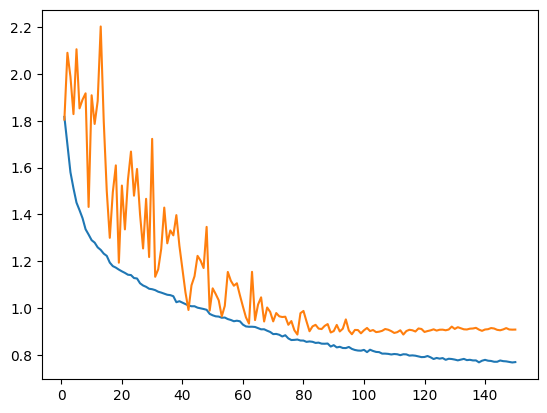

In [ ]:
plt.plot(epoch_range, train_loss)
plt.plot(epoch_range, val_loss)
plt.show()

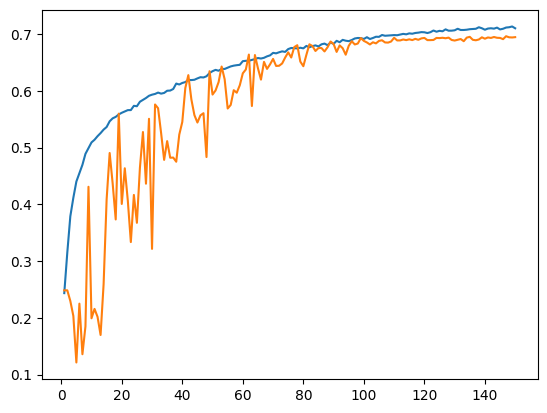

In [ ]:
plt.plot(epoch_range, train_acc)
plt.plot(epoch_range, val_acc)
plt.show()

In [ ]:
#load_model
model_load, optimizer_load = load_model(model,optimizer,checkpoint_path)


In [ ]:
data_test = valid_dataloader
#test_acc:
test_loss = 0
test_acc = 0
with torch.no_grad():
    for img, label in data_test:
      bs,nCrop,c,h,w = img.shape
      img = img.view(-1,c,h,w)

      img = img.to(device)
      label = label.to(device)

      outputs = model_load(img)

      outputs = outputs.view(bs, nCrop, -1)
      outputs = torch.sum(outputs, dim=1) / nCrop

      tloss = loss_fn(outputs, label)
      test_loss += tloss.item()
      test_acc += accuracy(outputs,label)

    test_accuracy = test_acc/len(data_test)


    print(f"valid_loss: {test_loss/len(data_test)}, valid_acc: {test_accuracy}")


valid_loss: 0.915536203928161, valid_acc: 0.6963267543859648


In [ ]:
data_test = test_dataloader
#test_acc:
test_loss = 0
test_acc = 0
with torch.no_grad():
    for img, label in data_test:
      bs,nCrop,c,h,w = img.shape
      img = img.view(-1,c,h,w)

      img = img.to(device)
      label = label.to(device)

      outputs = model_load(img)

      outputs = outputs.view(bs, nCrop, -1)
      outputs = torch.sum(outputs, dim=1) / nCrop

      tloss = loss_fn(outputs, label)
      test_loss += tloss.item()
      test_acc += accuracy(outputs,label)

    test_accuracy = test_acc/len(data_test)


    print(f"test_loss: {test_loss/len(data_test)}, test_acc: {test_accuracy}")

test_loss: 0.8402072384692075, test_acc: 0.7124999999999999


In [ ]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
change = {0:"Angry", 1: "Disgust",2 :"fear", 3:"Happy", 4:"Sad", 5:"Suprise", 6: "Neutral"}

In [ ]:
pd = enumerate(predict_dataloader)

In [ ]:
#Prediction:
def predict(image_batch, model, label):
    outputs = model(image_batch.to(device))
    predicted_class = torch.argmax(outputs, dim = 1)
    fig, axs = plt.subplots(8,1, figsize=(10, 40))
    batch_size = image_batch.shape[0]
    for index in range(batch_size):
         axs[index].imshow(image_batch[index].permute(1,2,0))
         axs[index].set_title(f'Predict: {change[int(predicted_class[index])]} - Label: {change[int(label[index])]} ')
    plt.show()



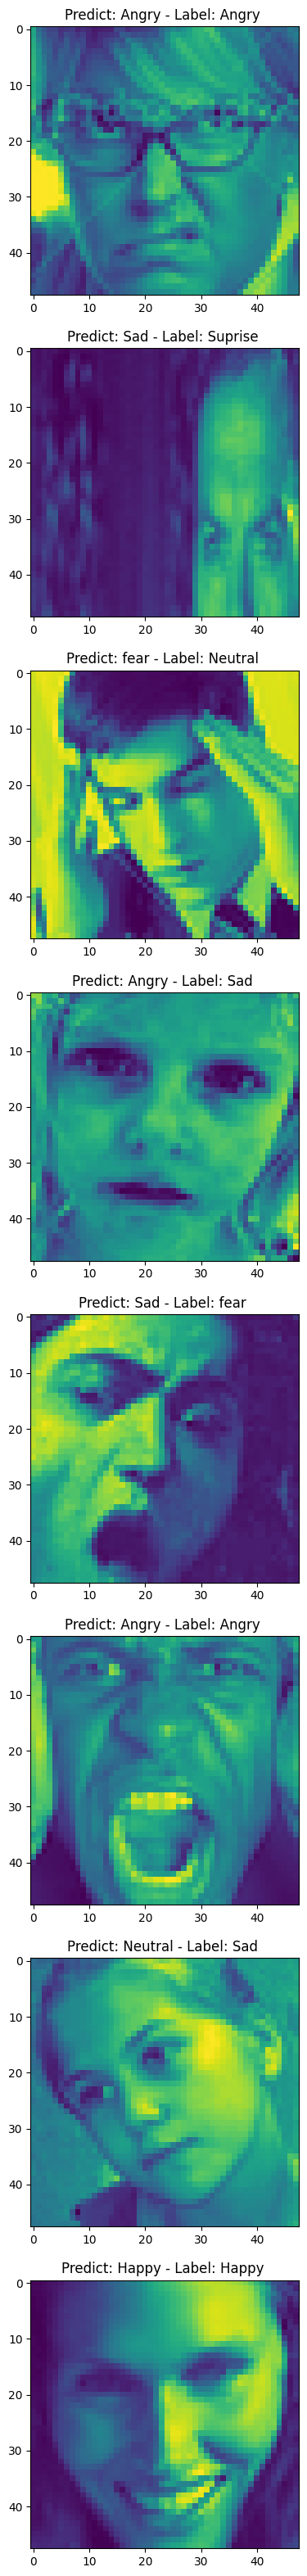

In [ ]:
i,(ib,l) = next(pd)
predict(ib,model_load,l)